##   Курсовой проект для курса "Python для Data Science" ##

### Задание:###
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

### Целевая переменная: ###
Price

### Метрика качества: ###
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### Описание датасета: ###
- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

Дедлайны и требования:
- Соревнование заказнчивается 29 апреля
- Необходимо получить R2 > 60% на __Private__ Leaderboard для успешного завершения курса
- Необходимо получить ранг "Contributor" в соревнованиях на Каггле: https://www.kaggle.com/progression
- Прислать в комментариях к ДЗ ссылка на решение проекта в git / public kaggle notebook

In [649]:
import datetime # для работы со времнем
import gc # сборщик мусора

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Чтение данных

## Загрузка данных и оптимизация памяти

In [650]:
df = pd.read_csv('/kaggle/input/realestatepriceprediction/train.csv')
X_final = pd.read_csv('/kaggle/input/realestatepriceprediction/test.csv')

def reduce_mem_usage(df):  
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

df = reduce_mem_usage(df)
X_final = reduce_mem_usage(X_final)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


In [651]:
X = df.drop('Price', axis=1)
y = df[['Price']]

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])


Строк в трейне: 10000
Строк в тесте 5000


In [652]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
Id               10000 non-null int16
DistrictId       10000 non-null int16
Rooms            10000 non-null float32
Square           10000 non-null float32
LifeSquare       7887 non-null float32
KitchenSquare    10000 non-null float32
Floor            10000 non-null int8
HouseFloor       10000 non-null float32
HouseYear        10000 non-null int32
Ecology_1        10000 non-null float32
Ecology_2        10000 non-null category
Ecology_3        10000 non-null category
Social_1         10000 non-null int8
Social_2         10000 non-null int16
Social_3         10000 non-null int16
Healthcare_1     5202 non-null float32
Helthcare_2      10000 non-null int8
Shops_1          10000 non-null int8
Shops_2          10000 non-null category
dtypes: category(3), float32(7), int16(4), int32(1), int8(4)
memory usage: 459.4 KB


In [653]:
X.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
dtype: object

### Распределение целевой переменной

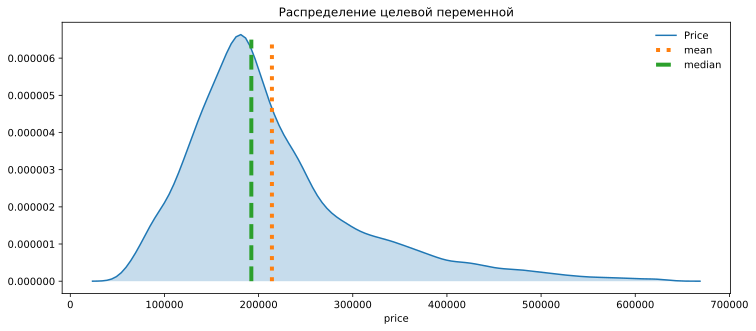

In [654]:
target = df[['Price']]

target_mean = round(target.mean(), 2)
target_median = round(target.median(), 2)

plt.figure(figsize = (12, 5))

sns.kdeplot(df['Price'], shade=True, legend=False)

plt.xlabel('price')

y = np.linspace(0, 0.0000065, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)

plt.title('Распределение целевой переменной')
plt.legend(frameon=False)
plt.show()

### Rooms

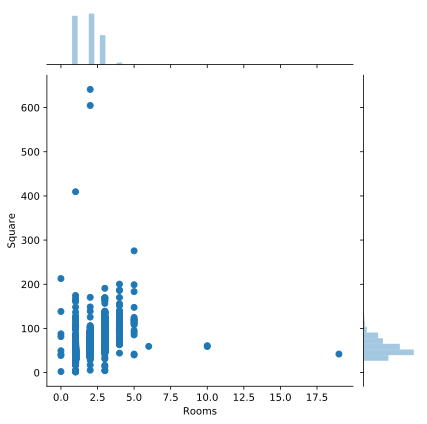

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [655]:
sns.jointplot(X['Rooms'],X['Square'])
plt.show()

X['Rooms'].value_counts().sort_values(na_position='last', ascending=False)
# > 6 комнат, = 0 комнат

### Square

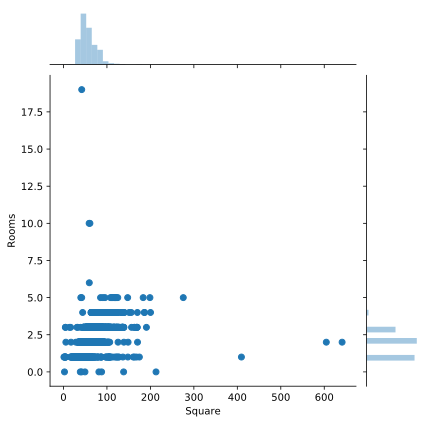

6392      1.136859
8283      1.988943
4853      2.377248
1608      2.596351
9294      2.954309
           ...    
1981    212.932358
1982    275.645294
4690    409.425171
4262    604.705994
6977    641.065186
Name: Square, Length: 10000, dtype: float32

In [656]:
sns.jointplot(X['Square'],X['Rooms']);
plt.show()
X['Square'].sort_values(na_position='last')

### LifeSquare

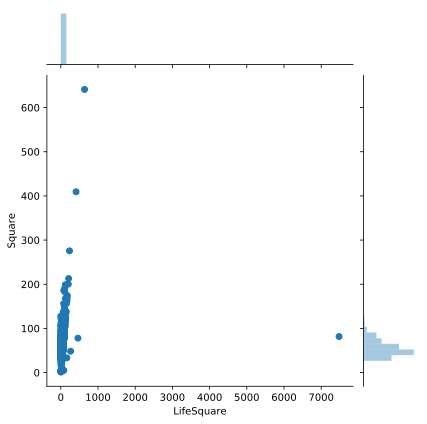

0       29.442751
1       40.049541
2       29.197611
3       52.731510
4       23.776169
          ...    
9995    30.476204
9996    20.539215
9997          NaN
9998    33.840149
9999    21.157875
Name: LifeSquare, Length: 10000, dtype: float32

In [657]:
X['LifeSquare'].sort_values(na_position='first', ascending=False)

sns.jointplot(X['LifeSquare'],X['Square']);

plt.show()

X['LifeSquare']

### KitchenSquare

### Floor

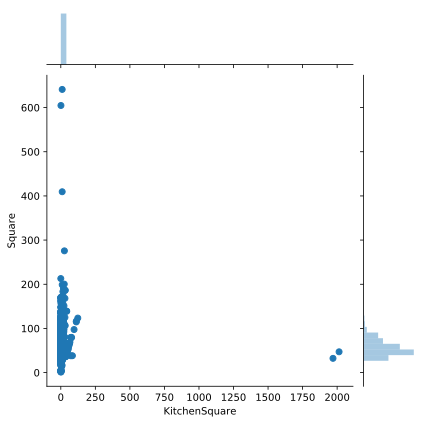

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
37.0         2
41.0         2
112.0        2
25.0         2
43.0         2
51.0         2
32.0         2
58.0         2
30.0         2
53.0         1
63.0         1
31.0         1
123.0        1
73.0         1
23.0         1
29.0         1
21.0         1
26.0         1
75.0         1
36.0         1
1970.0       1
39.0         1
62.0         1
42.0         1
84.0         1
27.0         1
78.0         1
60.0         1
35.0         1
2014.0       1
40.0         1
48.0         1
66.0         1
96.0         1
72.0         1
54.0         1
Name: KitchenSquare, dtype: int64

In [658]:
sns.jointplot(X['KitchenSquare'],X['Square']);
plt.show()
X['KitchenSquare'].value_counts().sort_values(na_position='last', ascending=False)
# Площадь < 3
# Площадь > 1000

### Floor

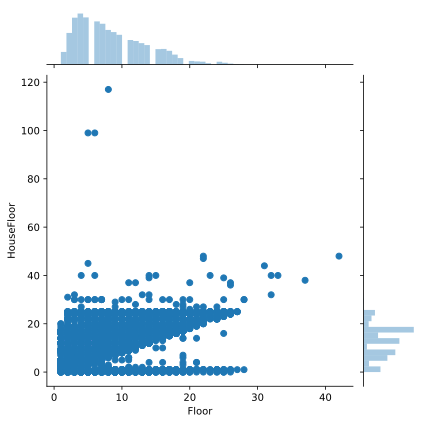

Unique: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 31 32 33 37 42]


4     949
5     876
3     872
6     802
7     759
8     643
9     604
2     588
10    553
11    457
12    438
13    398
14    362
16    290
15    287
17    256
1     235
18    185
19    121
20     68
21     59
22     54
24     53
25     34
23     25
26     18
27      5
28      3
32      2
37      1
42      1
33      1
31      1
Name: Floor, dtype: int64

In [659]:
sns.jointplot(X['Floor'],X['HouseFloor']);
plt.show()
unique = X['Floor'].sort_values().unique()
print(f'Unique: {unique}')
X['Floor'].value_counts().sort_values(na_position='first', ascending=False)

In [660]:
(X['Floor'] > X['HouseFloor']).sum()

1825

**HouseYear**

In [661]:
X['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [662]:
X[X['HouseYear'] > 2020].head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
1497  10814         109    1.0  37.265072   20.239714            9.0      9   
4189  11607         147    2.0  44.791836   28.360394            5.0      4   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1497        12.0   20052011   0.136330         B         B        30   
4189         9.0       4968   0.319809         B         B        25   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
1497      6141        10         262.0            3        6       B  
4189      4756        16        2857.0            5        8       B

**DistrictId**

In [664]:
X['DistrictId'].nunique()

205

(0, 120)

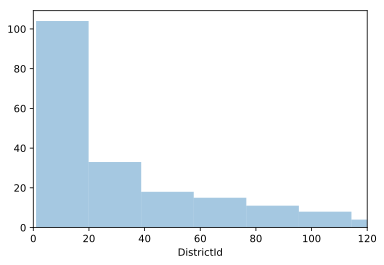

In [665]:

R = X['DistrictId'].value_counts()
sns.distplot(R, kde=False, bins=45)
plt.xlim(0, 120)

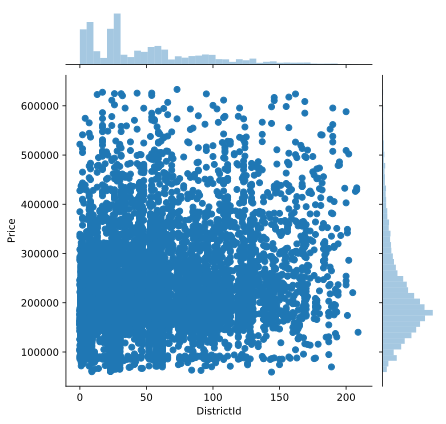

In [666]:
sns.jointplot(df['DistrictId'],df['Price']);
plt.show()

### Заполнение NaN

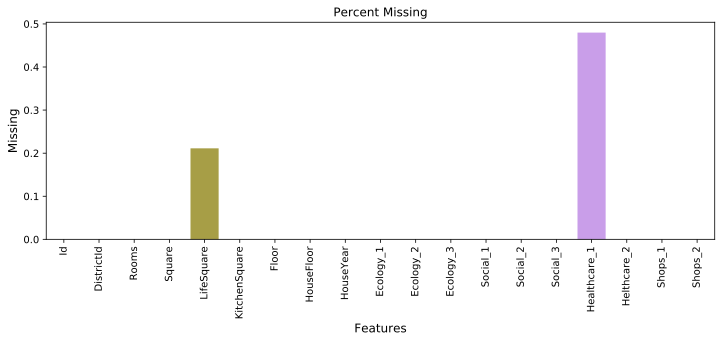

In [667]:
nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']


plt.figure(figsize=(12,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()


# Удалим Healthcare_1
# Заполним LifeSquare